# Chunking using RNN and also Bi-LSTM

## Importing required Libraries

In [1]:
# Let us import required Libraries

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import KeyedVectors

## Dataset

In [2]:
# Let us declare and load the dataset

DATA_DIR = '{}.txt'

def get_data(file):
    with open(file, 'r', encoding='latin1') as fp:
        content = fp.readlines()
    data, sent = [], []
    for line in content:
        if not line.strip():
            if sent: data.append(sent)
            sent = []
        else:
            word, pos, tag = line.strip().split()
            tag = tag.split('-')[0]
            sent.append((word, pos, tag))
    return data

In [3]:
train_data = get_data(DATA_DIR.format('train'))
test_data = get_data(DATA_DIR.format('test'))

In [4]:
# Declaring some of the factors

MAX_LEN = 78
empty_token = '<UNK>'
empty_pos = '^'
empty_tag = '$'
pad_value = 0
embed_dim = 300

In [5]:
# Now, we have to seperate the words and corresponding tags, so we will do the following

sentences_train = [' '.join([tup[0].lower() for tup in sent]) for sent in train_data]
sent_tokenizer = Tokenizer(oov_token=empty_token, filters='\t\n') 
sent_tokenizer.fit_on_texts(sentences_train)
sentences_train = sent_tokenizer.texts_to_sequences(sentences_train)
sentences_train = pad_sequences(sentences_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_WORDS = len(sent_tokenizer.word_index)

sentences_test = [' '.join([tup[0].lower() for tup in sent]) for sent in test_data]
sentences_test = sent_tokenizer.texts_to_sequences(sentences_test)
sentences_test = pad_sequences(sentences_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [6]:
postags_train = [' '.join([tup[1].lower() for tup in sent]) for sent in train_data]
pos_tokenizer = Tokenizer(oov_token=empty_pos, filters='\t\n') 
pos_tokenizer.fit_on_texts(postags_train)
postags_train = pos_tokenizer.texts_to_sequences(postags_train)
postags_train = pad_sequences(postags_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_POS = len(pos_tokenizer.word_index)

postags_test = [' '.join([tup[1].lower() for tup in sent]) for sent in test_data]
postags_test = pos_tokenizer.texts_to_sequences(postags_test)
postags_test = pad_sequences(postags_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [7]:
tags_train = [[tup[2] for tup in sent] for sent in train_data]
tag_tokenizer = Tokenizer(oov_token=empty_tag, filters='\t\n')
tag_tokenizer.fit_on_texts(tags_train)
tags_train = tag_tokenizer.texts_to_sequences(tags_train)
tags_train = pad_sequences(tags_train, padding='post', value=pad_value, maxlen=MAX_LEN)
NUM_TAGS = len(tag_tokenizer.word_index)

tags_test = [[tup[2] for tup in sent] for sent in test_data]
tags_test = tag_tokenizer.texts_to_sequences(tags_test)
tags_test = pad_sequences(tags_test, padding='post', value=pad_value, maxlen=MAX_LEN)

In [8]:
# Sentences, their Pos Tags and Chunk tags

l=8936
sentences_train,sentences_validation=sentences_train[:l*85//100],sentences_train[1+l*85//100:]
postags_train,postags_validation=postags_train[:l*85//100],postags_train[1+l*85//100:]
tags_train,tags_validation=tags_train[:l*85//100],tags_train[1+l*85//100:]
print(len(sentences_train),len(sentences_validation))
print(len(postags_train),len(postags_validation))
print(len(tags_train),len(tags_validation))

7595 1340
7595 1340
7595 1340


## Word-Embedding Model

In [9]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [10]:
def load_word2vec():
    embedding_matrix = np.random.normal(size=(NUM_WORDS + 1, embed_dim))
    for word, idx in sent_tokenizer.word_index.items():
        if word in wv.vocab:
            embedding_matrix[idx] = wv.word_vec(word)
    return embedding_matrix

In [11]:
# Loading Word2Vec Model

word2vec=load_word2vec()

In [12]:
def ignore_accuracy_of_class(class_to_ignore=0):
    def acc(y_true, y_pred):
        y_true_class=tf.cast(y_true, tf.int64)
        y_pred_class = K.argmax(y_pred, axis=-1)
        ignore_mask = K.cast(K.not_equal(y_pred_class, class_to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return acc

custom_acc = ignore_accuracy_of_class(pad_value)

## Bi-LSTM Model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Concatenate,SimpleRNN, RNN

def model_with_pos():
    with strategy.scope():
        custom_emb = keras.initializers.Constant(word2vec)
        regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)
        word_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        pos_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        word_emb = Embedding(NUM_WORDS + 1, embed_dim, embeddings_initializer=custom_emb, trainable=True)(word_inputs)
        pos_emb = Embedding(NUM_POS + 1, 25, trainable=True)(pos_inputs)
        emb = Concatenate(axis=-1)([word_emb, pos_emb])
        lstm = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=regularizer))(emb)
        td = TimeDistributed(Dense(NUM_TAGS + 1, activation='softmax', kernel_regularizer=regularizer))(lstm)
        model = Model(inputs=[word_inputs, pos_inputs], outputs=[td])
        return model

## Summary of the Model

In [15]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [16]:
K.clear_session()
model = model_with_pos()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 78, 300)      5178000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 78, 25)       1150        input_2[0][0]                    
______________________________________________________________________________________________

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

losses, val_losses = [], []
accs, val_accs = [], []
model_name = 'bilstm_chunker.h5'
stopper = EarlyStopping(monitor='acc', patience=5, mode='max')
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_acc', mode='max', save_best_only=True, verbose=2)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=[custom_acc])

In [18]:
history = model.fit(
    x = [sentences_train, postags_train],
    y = tags_train,
    validation_data = ([sentences_validation, postags_validation], tags_validation),
    callbacks = [stopper],
    epochs = 10,
    batch_size = 128 * strategy.num_replicas_in_sync,
    verbose = 1,
)

losses += list(history.history['loss'])
val_losses += list(history.history['val_loss'])

accs += list(history.history['acc'])
val_accs += list(history.history['val_acc'])

Train on 7595 samples, validate on 1340 samples
Epoch 1/10
7595/7595 [==============================] - 37s 5ms/sample - loss: 1.0420 - acc: 0.6268 - val_loss: 0.7518 - val_acc: 0.7339
Epoch 2/10
7595/7595 [==============================] - 25s 3ms/sample - loss: 0.6013 - acc: 0.8035 - val_loss: 0.4751 - val_acc: 0.8421
Epoch 3/10
7595/7595 [==============================] - 24s 3ms/sample - loss: 0.3945 - acc: 0.8779 - val_loss: 0.3318 - val_acc: 0.8944
Epoch 4/10
7595/7595 [==============================] - 24s 3ms/sample - loss: 0.2832 - acc: 0.9190 - val_loss: 0.2509 - val_acc: 0.9235
Epoch 5/10
7595/7595 [==============================] - 23s 3ms/sample - loss: 0.2191 - acc: 0.9395 - val_loss: 0.2043 - val_acc: 0.9320
Epoch 6/10
7595/7595 [==============================] - 23s 3ms/sample - loss: 0.1797 - acc: 0.9475 - val_loss: 0.1736 - val_acc: 0.9364
Epoch 7/10
7595/7595 [==============================] - 24s 3ms/sample - loss: 0.1528 - acc: 0.9529 - val_loss: 0.1530 - val_acc: 

## Plots

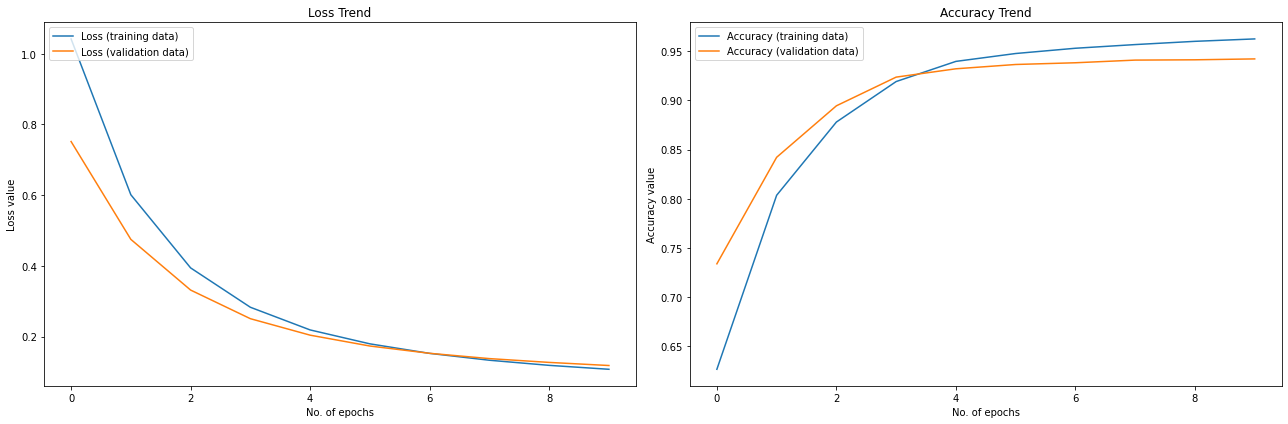

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(losses, label='Loss (training data)')
ax[0].plot(val_losses, label='Loss (validation data)')
ax[0].set_title('Loss Trend')
ax[0].set_ylabel('Loss value')
ax[0].set_xlabel('No. of epochs')
ax[0].legend(loc="upper left")

ax[1].plot(accs, label='Accuracy (training data)')
ax[1].plot(val_accs, label='Accuracy (validation data)')
ax[1].set_title('Accuracy Trend')
ax[1].set_ylabel('Accuracy value')
ax[1].set_xlabel('No. of epochs')
ax[1].legend(loc="upper left")

plt.tight_layout()

plt.savefig('loss_acc_trend.png', bbox_inches='tight')
plt.show()

## RNN Model

In [20]:
def rnn_model_with_pos():
    with strategy.scope():
        custom_emb = keras.initializers.Constant(word2vec)
        regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3)
        word_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        pos_inputs = Input(shape=(MAX_LEN,), dtype='int32')
        word_emb = Embedding(NUM_WORDS + 1, embed_dim, embeddings_initializer=custom_emb, trainable=True)(word_inputs)
        pos_emb = Embedding(NUM_POS + 1, 25, trainable=True)(pos_inputs)
        emb = Concatenate(axis=-1)([word_emb, pos_emb])
        rnn = SimpleRNN(32, return_sequences=True, kernel_regularizer=regularizer)(emb)
        td = TimeDistributed(Dense(NUM_TAGS + 1, activation='softmax', kernel_regularizer=regularizer))(rnn)
        model = Model(inputs=[word_inputs, pos_inputs], outputs=[td])
        return model

## Summary of the Model

In [23]:
rnn_model = rnn_model_with_pos()
print(rnn_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 78)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 78, 300)      5178000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 78, 25)       1150        input_4[0][0]                    
____________________________________________________________________________________________

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

rnn_losses, rnn_val_losses = [], []
rnn_accs, rnn_val_accs = [], []
rnn_model_name = 'rnn_chunker.h5'
stopper = EarlyStopping(monitor='acc', patience=5, mode='max')
checkpointer = ModelCheckpoint(filepath=rnn_model_name, monitor='val_acc', mode='max', save_best_only=True, verbose=2)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=[custom_acc])

In [25]:
rnn_history = rnn_model.fit(
    x = [sentences_train, postags_train],
    y = tags_train,
    validation_data = ([sentences_validation, postags_validation], tags_validation),
    callbacks = [stopper],
    epochs = 10,
    batch_size = 128 * strategy.num_replicas_in_sync,
    verbose = 1,
)

rnn_losses += list(rnn_history.history['loss'])
rnn_val_losses += list(rnn_history.history['val_loss'])

rnn_accs += list(rnn_history.history['acc'])
rnn_val_accs += list(rnn_history.history['val_acc'])

Train on 7595 samples, validate on 1340 samples
Epoch 1/10
7595/7595 [==============================] - 15s 2ms/sample - loss: 0.5739 - acc: 0.6699 - val_loss: 0.3231 - val_acc: 0.8435
Epoch 2/10
7595/7595 [==============================] - 10s 1ms/sample - loss: 0.2710 - acc: 0.8844 - val_loss: 0.2452 - val_acc: 0.8925
Epoch 3/10
7595/7595 [==============================] - 10s 1ms/sample - loss: 0.2198 - acc: 0.9166 - val_loss: 0.2134 - val_acc: 0.9119
Epoch 4/10
7595/7595 [==============================] - 11s 1ms/sample - loss: 0.1929 - acc: 0.9330 - val_loss: 0.1936 - val_acc: 0.9210
Epoch 5/10
7595/7595 [==============================] - 10s 1ms/sample - loss: 0.1742 - acc: 0.9420 - val_loss: 0.1792 - val_acc: 0.9263
Epoch 6/10
7595/7595 [==============================] - 10s 1ms/sample - loss: 0.1598 - acc: 0.9482 - val_loss: 0.1678 - val_acc: 0.9287
Epoch 7/10
7595/7595 [==============================] - 10s 1ms/sample - loss: 0.1480 - acc: 0.9526 - val_loss: 0.1588 - val_acc: 

## Plots

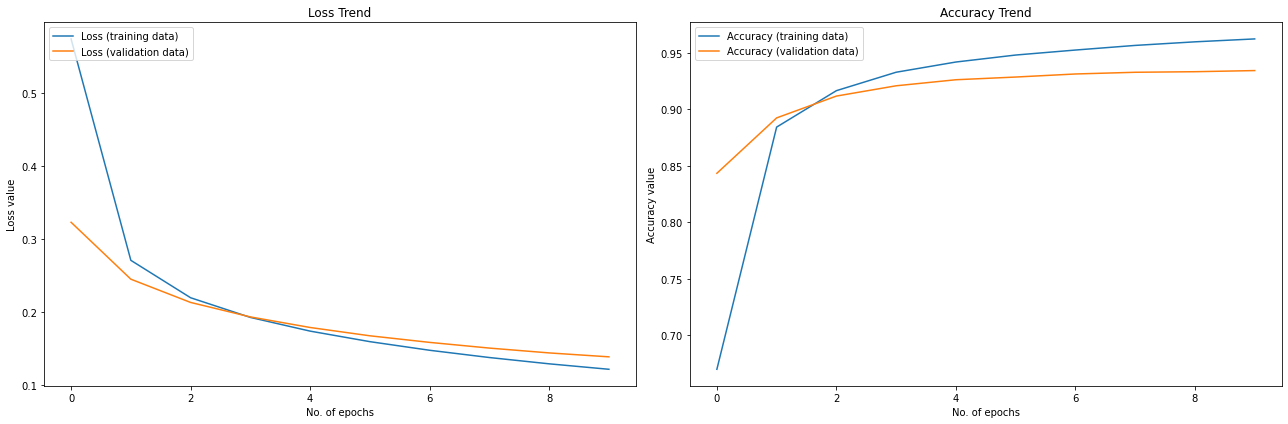

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(rnn_losses, label='Loss (training data)')
ax[0].plot(rnn_val_losses, label='Loss (validation data)')
ax[0].set_title('Loss Trend')
ax[0].set_ylabel('Loss value')
ax[0].set_xlabel('No. of epochs')
ax[0].legend(loc="upper left")

ax[1].plot(rnn_accs, label='Accuracy (training data)')
ax[1].plot(rnn_val_accs, label='Accuracy (validation data)')
ax[1].set_title('Accuracy Trend')
ax[1].set_ylabel('Accuracy value')
ax[1].set_xlabel('No. of epochs')
ax[1].legend(loc="upper left")

plt.tight_layout()

plt.savefig('loss_acc_trend.png', bbox_inches='tight')
plt.show()